In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Exploratory Data analysis of ProPublica's Compas data

## Load data and recreate filters from ProPublica

In [2]:
# Load data and transform date columsn to "datetime"
raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape

(7214, 53)

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.*

In [3]:
# Select columns of interest and store as new df
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(df["score_text"]!="N/A")
      ]

df.shape

(6172, 13)

In [6]:
#Change dtype for categorical features
category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'is_recid', 'two_year_recid']
df = df.apply(lambda s: s.astype('category') if s.name in category_cols else s)

## Demographic breakdown

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [18]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
    .loc["length_of_stay_days","decile_score"],5)

0.20748

After filtering we have the following demographic breakdown:

In [19]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [37]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [26]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [29]:
pd.crosstab(df["sex"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [30]:
df.sex.value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [36]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.96%
Female    19.04%
Name: sex, dtype: object

In [53]:
no_recid = np.sum(df["two_year_recid"]==1)
print("Number of entries with two_year_recid:", no_recid)
print("% of entries with two_year_recid", np.round(no_recid/df.shape[0]*100,2))

Number of entries with two_year_recid: 2809
% of entries with two_year_recid 45.51


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

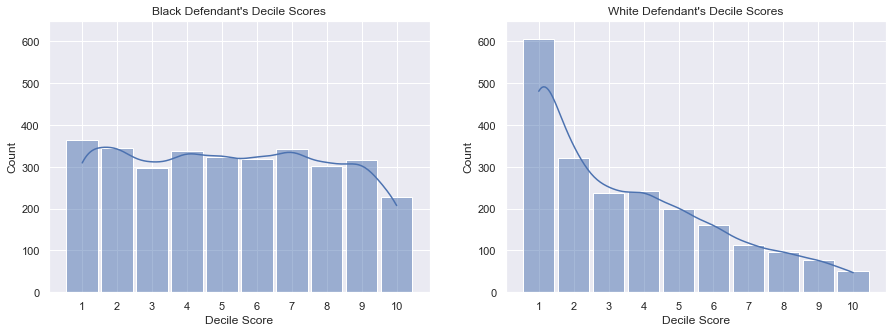

In [150]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");


In [152]:
pd.crosstab(df["decile_score"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7
